# Interactive Urban Flood Predictor

In [1]:
import tensorflow as tf
import numpy as np

# import neural net code
import nn
import model_portugal.nn_model as nn_model

# import data loader
import load_data.load_npy as ld

# import ipywidgets (interaction library)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# import ploting library
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.colorbar import colorbar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as colors

from scipy.stats import norm

## CNN Model

In [2]:
initializer = tf.contrib.layers.xavier_initializer()
af = tf.nn.leaky_relu
phs, ls, vs = nn_model.prediction_network(initializer, af)

Tensor("e1_c_0:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("e1_c_1:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("e1:0", shape=(?, 128, 128, 16), dtype=float32)
Tensor("e2_c_0:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("e2_c_1:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("e2:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("e3_c_0:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("e3_c_1:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("e3:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("concat:0", shape=(?, 32, 32, 132), dtype=float32)
Tensor("d3_c_0:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("d3_c_1:0", shape=(?, 32, 32, 64), dtype=float32)
output shape [64, 64]
Tensor("d3:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("d2_c_0:0", shape=(?, 64, 64, 16), dtype=float32)
Tensor("d2_c_1:0", shape=(?, 64, 64, 16), dtype=float32)
output shape [128, 128]
Tensor("d2:0", shape=(?, 128, 128, 16), dtype=float32)
Tensor("p_c_0:0", shape=(?, 128, 128, 1), dtyp

## Terrain Data

In [3]:
path_terrain = "data/portugal/terrain.npy"
arr_terrain=np.transpose(np.load(path_terrain),[1,2,0]) #[h,w,c] format

indice_patch_grid=ld.get_patch_indice_grid(arr_terrain.shape[0],arr_terrain.shape[1],nn_model.IMG_SIZE)
indice_patch_random=ld.get_patch_indice_random(arr_terrain.shape[0],arr_terrain.shape[1],100,nn_model.IMG_SIZE,seed=12)

patch_terrain_grid=ld.get_patches(arr_terrain, indice_patch_grid)
patch_terrain_random=ld.get_patches(arr_terrain, indice_patch_random)

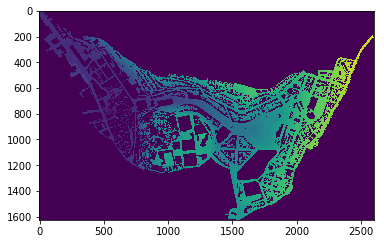

In [27]:
plt.imshow(arr_terrain[:,:,0])

## Restore CNN Model

In [4]:
path_model="data/model/portugal_shuffle_pattern/-499"

sess=tf.Session()
tf.global_variables_initializer().run(session=sess)
saver = tf.train.Saver()
saver.restore(sess,path_model)

INFO:tensorflow:Restoring parameters from data/model/portugal_shuffle_pattern/-499


## Making Prediction

functions

In [28]:
def make_prediction(height, width, pattern, patch_terrain, indice_terrain, truth=None, batch_num=8):
    '''
    making prediction using given patches and rain pattern
    
    parameters:
    ---------------
    height and width: the size of the overall prediction area
    pattern: rain pattern
    
    patch_terrain: patches, each patch must be "HWC" format
    indice_terrain: indices of the patches
    
    truth: ground truth for all area, if error map is needed
    
    batch_num: batch number
    
    returns:
    ---------------
    mean, max, n(how many patches for each pixel), stddev, error_mean(if truth is provided), error_max(if truth is provided)
    '''
    
    IMG_SIZE=nn_model.IMG_SIZE
    patch_num = len(patch_terrain)
    
    max_water_level = np.zeros([height, width])
    sum_water_level = np.zeros([height, width])
    sum_sq_water_level = np.zeros([height, width])
    n_water_level = np.zeros([height, width])
    mask_all=np.ones([height, width],np.uint8)
    
    i = 0
    while i < patch_num:
        # start / end of the patches
        start = i
        end = min(i + batch_num,patch_num)

        # index of patches, from start to end
        index = np.arange(start=start,stop=end)
        
        # rain patther of patches, constant array
        id_pattern = np.zeros_like(index,dtype=np.uint8)

        predict = sess.run(ls["prediction"], feed_dict={phs["x1"]:patch_terrain[index], phs["x2"]:pattern[id_pattern]})
        # assemble patches
        for j in range(start, end):
            h1, w1, h2, w2 = indice_terrain[j]
            
            n_water_level[h1:h2, w1:w2]+=1
            
            sum_water_level[h1:h2, w1:w2] += predict[j-start] # sum
            
            sum_sq_water_level[h1:h2, w1:w2] += np.square(predict[j-start]) # sum of squares
            
            max_water_level[h1:h2, w1:w2] = np.maximum(max_water_level[h1:h2, w1:w2], predict[j-start]) # max
            
            mask_all[h1:h2, w1:w2]=patch_terrain[j,:,:,1]
            
        i+=batch_num

    # calculate mean value
    mask = n_water_level != 0
    mean_water_level=sum_water_level.copy()
    mean_water_level[mask]/=n_water_level[mask]
    
    if truth is not None:
        error_mean = np.abs(truth[0:height,0:width]-mean_water_level)
        error_max = np.abs(truth[0:height,0:width]-max_water_level)
    
    # stddev = sqrt(sum_sq / n - mean^2)
    stddev_water_level=sum_sq_water_level.copy()
    stddev_water_level[mask]/=n_water_level[mask]
    stddev_water_level-=np.square(mean_water_level)
    stddev_water_level=np.sqrt(np.abs(stddev_water_level)) # there are tiny numbers that are negative but close to 0
    
    mask=mask_all==1
    mean_water_level[mask]=np.nan
    max_water_level[mask]=np.nan
    n_water_level[mask]=np.nan
    stddev_water_level[mask]=np.nan
    
    if truth is not None:
        error_mean[mask]=np.nan
        error_max[mask]=np.nan
        return [mean_water_level, max_water_level, n_water_level, stddev_water_level, error_mean, error_max]
    
    return [mean_water_level, max_water_level, n_water_level, stddev_water_level]

In [56]:
def render_prediction(pred, pattern,filename=None):
    watermap = colors.LinearSegmentedColormap.from_list("watermap", plt.cm.Blues(np.linspace(0.15,1,256)), N=256)
    mean_water_level, max_water_level, n_water_level, stddev_water_level = pred
    
    fig = plt.figure(figsize=(30,15),constrained_layout=True)
    gs = GridSpec(2, 5, figure=fig)
    ax = fig.add_subplot(gs[0,0])
    ax.set_ylim(0,160)
    ax.plot(pattern[0])
    ax.set_title("rain pattern")
        
    ax = fig.add_subplot(gs[0,1:3])
    colorbar(ax.imshow(max_water_level,cmap=watermap,vmin=0,vmax=2), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad="2%"))
    ax.set_title("max water level")
    
    ax = fig.add_subplot(gs[0,3:5])
    colorbar(ax.imshow(mean_water_level,cmap=watermap,vmin=0,vmax=2), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad="2%"))
    ax.set_title("mean water level")
    
    ax = fig.add_subplot(gs[1,1:3])
    colorbar(ax.imshow(n_water_level), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad="2%"))
    ax.set_title("num of patch")
    
    ax = fig.add_subplot(gs[1,3:5])
    colorbar(ax.imshow(stddev_water_level,vmin=0,vmax=0.5), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad="2%"))
    ax.set_title("stddev")
    
    if filename is None:
        plt.show()
    else:
        plt.savefig("data/images/" + filename + ".png")
    

generate one rain pattern and then make prediction

In [57]:
height=arr_terrain.shape[0]
width=arr_terrain.shape[1]

# grid patch + random patch
patches=np.concatenate((patch_terrain_random,patch_terrain_grid))
indices=np.concatenate((indice_patch_random,indice_patch_grid))

def generate_rain_pattern(mu,sigma,minval,maxval):
    n=nn_model.PATTERN_RESOLUTION
    pattern=norm.pdf(np.arange(n)/(n-1) * 10,mu,sigma)
    pattern/=np.max(pattern)
    pattern*=(maxval-minval)
    pattern+=minval
    
    pattern=pattern[np.newaxis]

    pred=make_prediction(height,width,pattern,patches,indices,batch_num=24)
    render_prediction(pred, pattern)

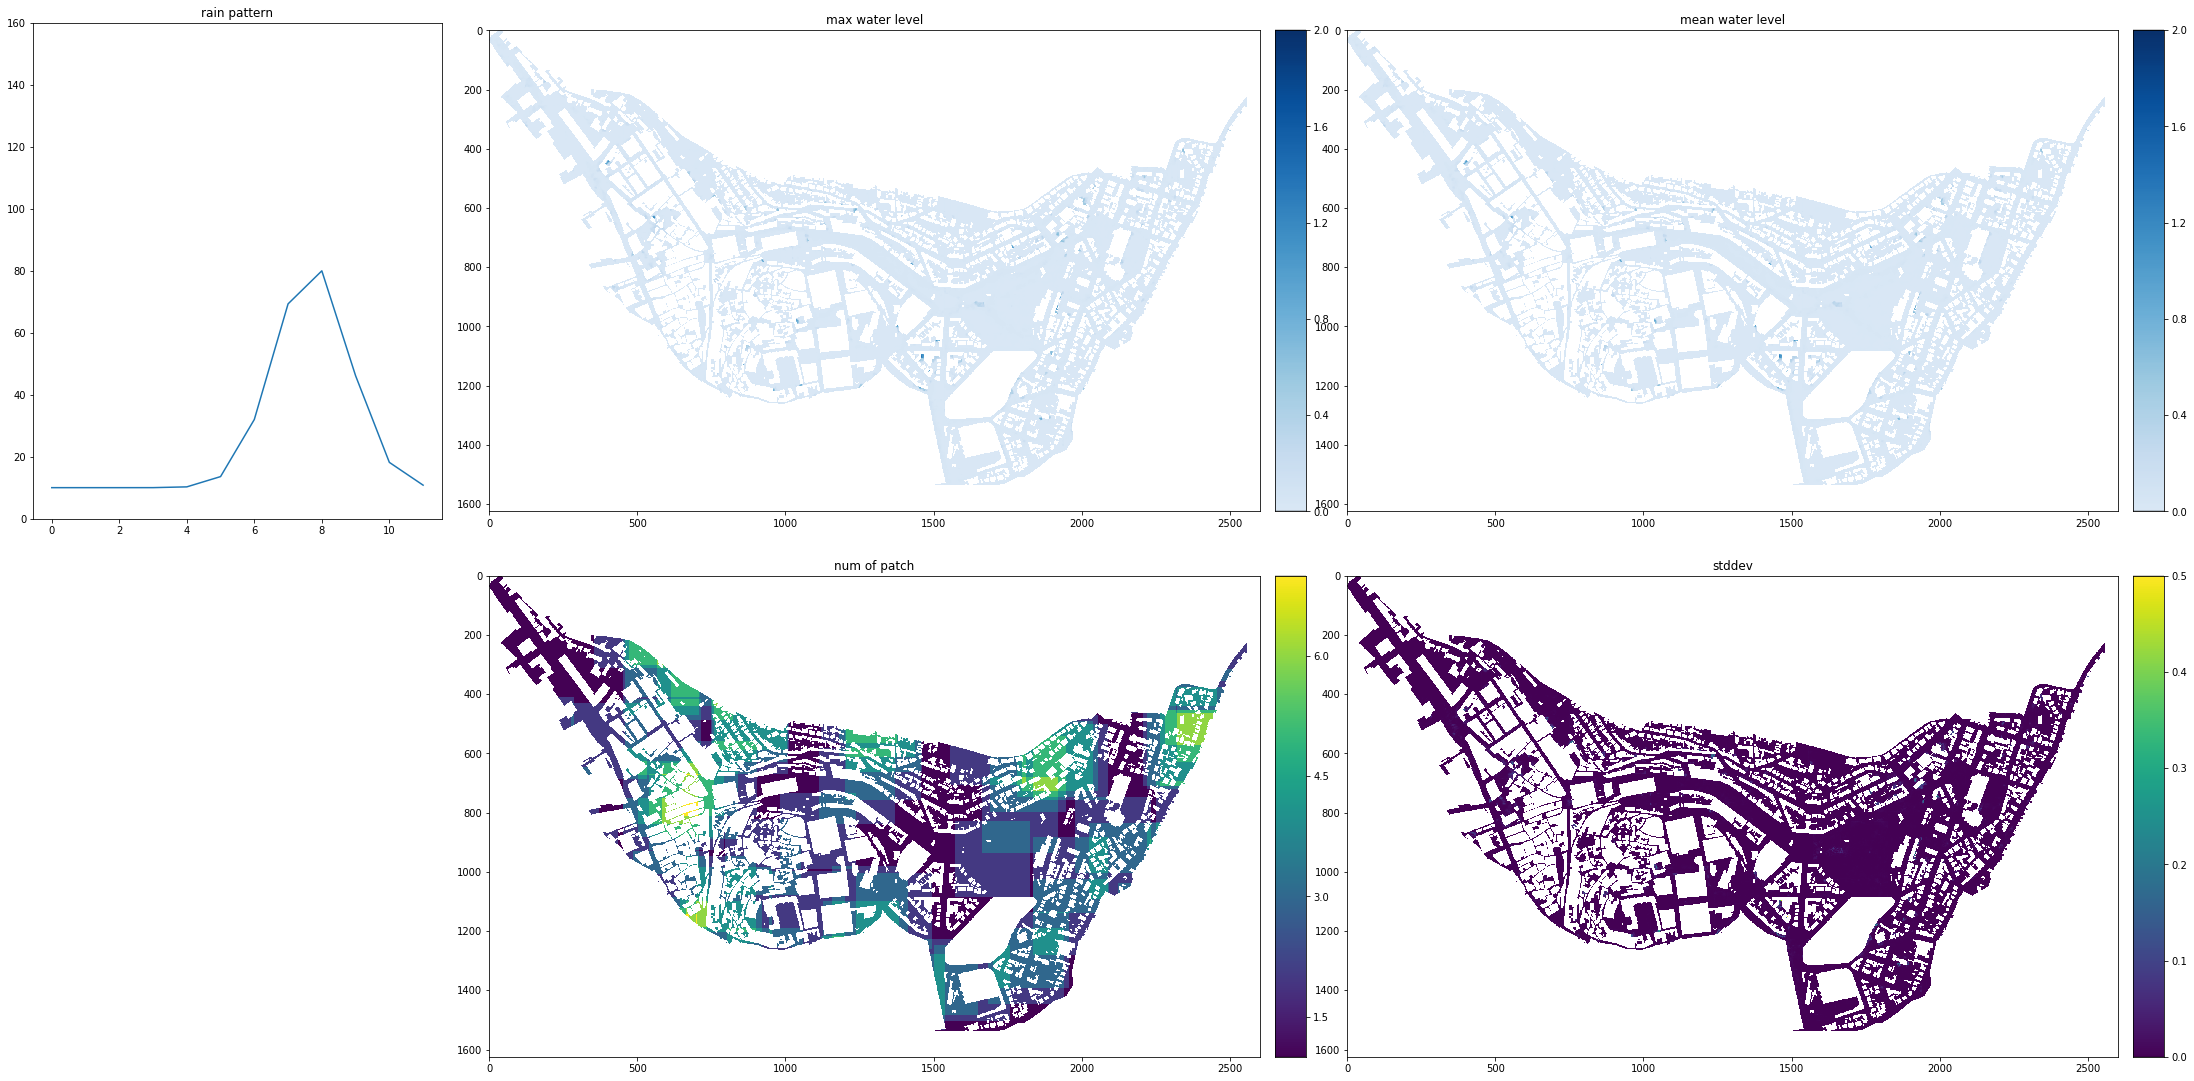

In [58]:
generate_rain_pattern(7,1,10,80)

interactive version

In [59]:
interact(generate_rain_pattern,mu=widgets.FloatSlider(min=0,max=nn_model.PATTERN_RESOLUTION,step=0.5,value=nn_model.PATTERN_RESOLUTION/2),sigma=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=0.1),minval=widgets.IntSlider(min=0,max=40,step=10,value=20),maxval=widgets.IntSlider(min=80,max=160,step=10,value=80))

interactive(children=(FloatSlider(value=6.0, description='mu', max=12.0, step=0.5), FloatSlider(value=0.1, des…

<function __main__.generate_rain_pattern>

## On Testing Data

In [35]:
path_water_level = "data/portugal/water_level.npy"
path_rain_pattern = "data/portugal/rain_pattern.txt"
# name of the rain patterns
SAMPLE_PATTERN = {0:"tr2-1",1:"tr5-1",2:"tr10-1",3:"tr20-1",4:"tr50-1",5:"tr100-1",6:"tr2-2",7:"tr5-2",8:"tr10-2",9:"tr20-2",10:"tr50-2",11:"tr100-2",12:"tr2-3",13:"tr5-3",14:"tr10-3",15:"tr50-3",16:"tr100-3"}

arr_truth=np.load(path_water_level)
rain_pattern = np.loadtxt(path_rain_pattern,delimiter='\t')

In [53]:
height=arr_terrain.shape[0]
width=arr_terrain.shape[1]

# grid patch + random patch
patches=np.concatenate((patch_terrain_random,patch_terrain_grid))
indices=np.concatenate((indice_patch_random,indice_patch_grid))

def test_rain_pattern(pattern_index):
    pattern=rain_pattern[pattern_index:pattern_index+1]
    truth=arr_truth[pattern_index]
    
    mean_water_level, max_water_level, _, _, error_mean,error_max = make_prediction(height,width,pattern,patches,indices,truth,batch_num=24)
    
    watermap = colors.LinearSegmentedColormap.from_list("watermap", plt.cm.Blues(np.linspace(0.15,1,256)), N=256)
    errormap = colors.LinearSegmentedColormap.from_list("errormap", plt.cm.Reds(np.linspace(0.15,1,256)), N=256)
    
    fig = plt.figure(figsize=(30,15),constrained_layout=True)
    gs = GridSpec(2, 5, figure=fig)
    ax = fig.add_subplot(gs[0,0])
    ax.set_ylim(0,160)
    ax.plot(pattern[0])
    ax.set_title(str(SAMPLE_PATTERN[pattern_index]))
        
    ax = fig.add_subplot(gs[0,1:3])
    colorbar(ax.imshow(max_water_level,cmap=watermap,vmin=0,vmax=2), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad="2%"))
    ax.set_title("max water level")
    
    ax = fig.add_subplot(gs[0,3:5])
    colorbar(ax.imshow(mean_water_level,cmap=watermap,vmin=0,vmax=2), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad="2%"))
    ax.set_title("mean water level")
    
    ax = fig.add_subplot(gs[1,1:3])
    colorbar(ax.imshow(error_mean,cmap=errormap,vmin=0,vmax=0.5), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad="2%"))
    ax.set_title("error on mean level")
    
    ax = fig.add_subplot(gs[1,3:5])
    colorbar(ax.imshow(error_max,cmap=errormap,vmin=0,vmax=0.5), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad="2%"))
    ax.set_title("error on max level")
    

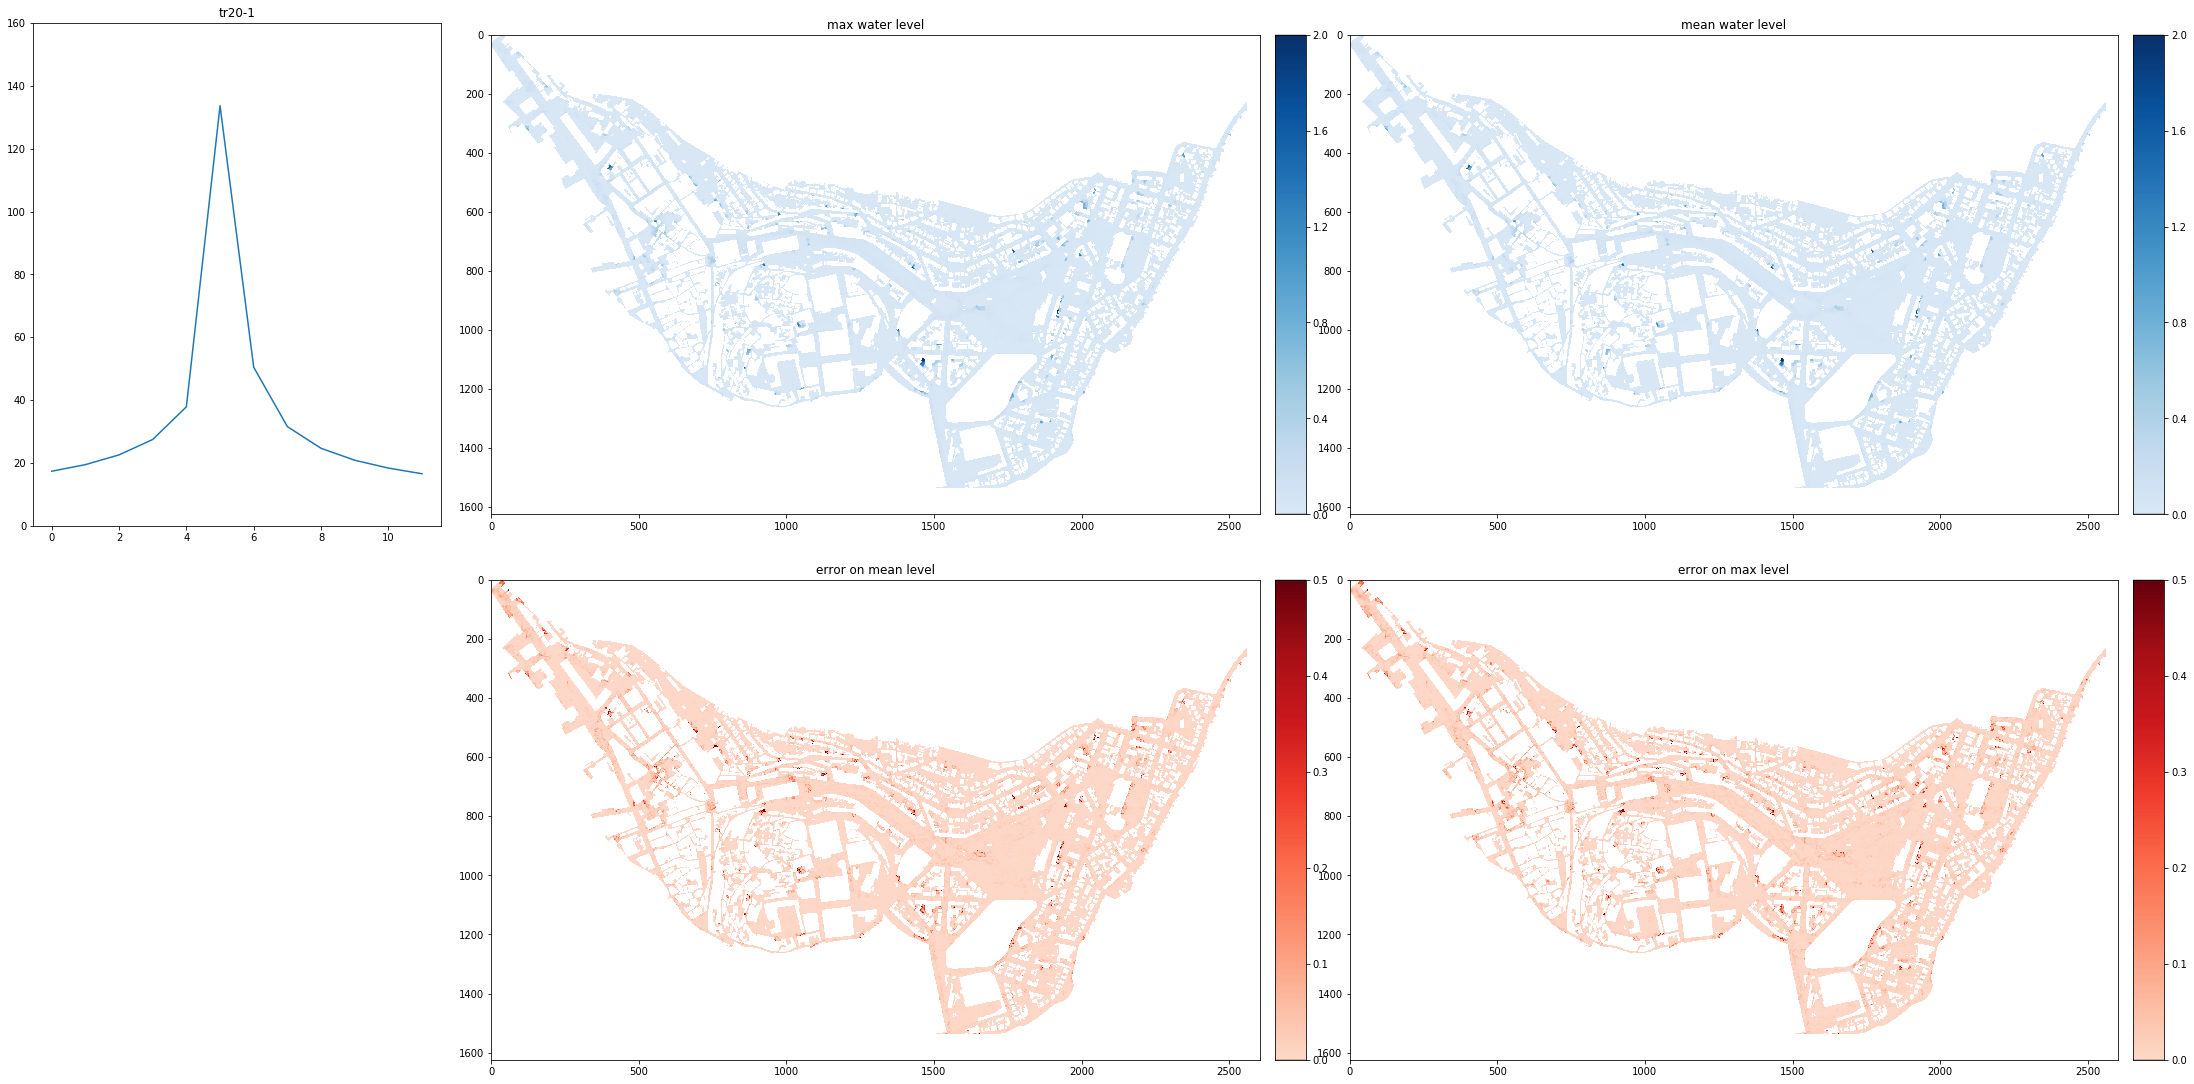

In [54]:
test_rain_pattern(3)

In [55]:
interact(test_rain_pattern,pattern_index=widgets.IntSlider(min=0,max=len(SAMPLE_PATTERN),step=1,value=0))

interactive(children=(IntSlider(value=0, description='pattern_index', max=17), Output()), _dom_classes=('widge…

<function __main__.test_rain_pattern>

old code

In [ ]:
batch_num=8
path_terrain = "data/portugal/terrain.npy"
path_water_level = "data/portugal/water_level.npy"
path_rain_pattern = "data/portugal/rain_pattern.txt"

patch_terrain, patch_water_levels, rain_patterns, grid_shape, img_shape = ld.load_terrain_grid(path_terrain, path_water_level, path_rain_pattern, nn_model.IMG_SIZE)

def make_prediction(pattern):
    IMG_SIZE=nn_model.IMG_SIZE
    watermap = colors.LinearSegmentedColormap.from_list("watermap", plt.cm.Blues(np.linspace(0.15,1,256)), N=256)
    
    patch_num = len(patch_terrain)
    predict_water_level = np.zeros([grid_shape[0] * IMG_SIZE,grid_shape[1] * IMG_SIZE])
    i = 0
    while i < patch_num:
        start = i
        end = min(i + batch_num,patch_num)

        # index of patches, from start to end
        index = np.arange(start=start,stop=end)
        # h, w position of patches
        h = index // grid_shape[1]
        w = index % grid_shape[1]
        # rain patther of patches, constant array
        id_pattern = np.zeros_like(index,dtype=np.uint8)

        predict = sess.run(ls["prediction"], feed_dict={phs["x1"]:patch_terrain[index], phs["x2"]:pattern[id_pattern]})

        # assemble patches
        for j in range(end - start):
            predict_water_level[h[j] * IMG_SIZE:(h[j] + 1) * IMG_SIZE, w[j] * IMG_SIZE:(w[j] + 1) * IMG_SIZE] = predict[j]
            # set mask for the result
            mask=patch_terrain[index[j],:,:,1]==1
            predict_water_level[h[j] * IMG_SIZE:(h[j] + 1) * IMG_SIZE, w[j] * IMG_SIZE:(w[j] + 1) * IMG_SIZE][mask]=np.nan
            
        i+=batch_num

    fig = plt.figure(figsize=(30,12),constrained_layout=True)
    gs = GridSpec(1, 4, figure=fig)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1:])

    ax1.set_ylim(0,160)
    ax1.plot(pattern[0])
    colorbar(ax2.imshow(predict_water_level,cmap=watermap,vmin=0,vmax=2), cax=make_axes_locatable(ax2).append_axes("right", size="4%", pad="2%"))
    
    plt.show()

def generate_rain_pattern(mu,sigma,minval,maxval):
    n=nn_model.PATTERN_RESOLUTION
    arr=norm.pdf(np.arange(n)/(n-1) * 10,mu,sigma)
    arr/=np.max(arr)
    arr*=(maxval-minval)
    arr+=minval
    # display the rain pattern
    make_prediction(arr[np.newaxis])